In [33]:
import random

In [34]:
import matplotlib.pyplot as plt

In [35]:
import csv


def find_max_map(file_path):
    with open(file_path, mode="r", newline="") as csvfile:
        reader = csv.reader(x.replace("\0", "") for x in csvfile)
        header = next(reader)  # Read the header
        # Find the index of the 'metrics/mAP50-95(B)' column (8th column, zero-indexed as 7)
        map_column_index = 7

        # Initialize max value
        max_map_value = float("-inf")

        # Iterate over the rows and find the max value
        for row in reader:
            try:
                # Convert the value to float and update max_map_value if current value is higher
                map_value = float(row[map_column_index].strip())
                max_map_value = max(max_map_value, map_value)
            except ValueError:
                # Handle cases where conversion to float fails (e.g., empty or non-numeric values)
                continue

        return max_map_value


# Example usage:
# max_value = find_max_map('your_file.csv')
# print("Max mAP50-95(B):", max_value)

In [36]:
def find_max_metric(file_path, metric_column):
    """
    Extracts the maximum value for a specified metric from a CSV file.

    :param file_path: Path to the CSV file.
    :param metric_column: Name of the column containing the desired metric.
    :return: The maximum value for the specified metric, or None if not found.
    """
    with open(file_path, mode="r", newline="") as csvfile:
        reader = csv.reader(x.replace("\0", "") for x in csvfile)
        headers = next(reader)  # Read the headers row
        headers = [x.lstrip() for x in headers]
        # Get the index of the specified metric column
        if metric_column == "fscore":
            precision_index = headers.index("metrics/precision(B)")
            recall_index = headers.index("metrics/recall(B)")
            max_metric_value = float("-inf")
            found = False

            # Iterate over the rows to find the max value for the specified column
            for row in reader:
                try:
                    precision = float(row[precision_index].strip())
                    recall = float(row[recall_index].strip())
                    fscore = 2 * precision * recall / (precision + recall)
                    max_metric_value = max(max_metric_value, fscore)
                    found = True
                except (ValueError, IndexError):
                    # Skip rows with invalid or missing values
                    continue
        else:
            try:
                column_index = headers.index(metric_column)
            except ValueError:
                raise ValueError(f"Column '{metric_column}' not found in CSV headers.")

            max_metric_value = float("-inf")
            found = False

            # Iterate over the rows to find the max value for the specified column
            for row in reader:
                try:
                    metric_value = float(row[column_index].strip())
                    max_metric_value = max(max_metric_value, metric_value)
                    found = True
                except (ValueError, IndexError):
                    # Skip rows with invalid or missing values
                    continue

        return max_metric_value if found else None

In [37]:
def get_results(methods, base_path, fractions, metric):
    # Initialize results
    results = {key: [] for key in methods.keys()}

    # Populate results
    for fraction in fractions:
        for method, info in methods.items():
            if fraction == "0.2" and method != "random":
                # Only "random" exists for 0.2; append None or a default value
                results[method].append(None)  # Or use a fallback value if needed
            else:
                file_path = base_path.format(
                    method=info["path"].format(fraction=fraction)
                )
                results[method].append(find_max_metric(file_path, metric))

    # Special handling for missing values (e.g., for 0.2 in non-random methods)
    for method in methods.keys():
        if results[method][0] is None:
            results[method][0] = results["random"][
                0
            ]  # Assign the random value if necessary

    return results

In [38]:
linestyles = ["-", "--", "-.", ":"]
markers = ["o", "v", "^", "<"]

In [39]:
import matplotlib

In [40]:
font = {"size": 14}

matplotlib.rc("font", **font)

In [41]:
import pandas as pd


def get_metrics_dataframe(methods, base_path, fractions, metrics):
    data = []
    index = []

    for metric in metrics:
        results = get_results(methods, base_path, fractions, metric)

        for method in methods:
            data.append([round(x, 4) for x in results[method]])
            index.append((metric, method))

    df = pd.DataFrame(
        data,
        index=pd.MultiIndex.from_tuples(index, names=["Metric", "Method"]),
        columns=fractions,
    )

    return df

In [42]:
base_path = "/home/setupishe/ultralytics/runs/detect/COCO_{method}/results.csv"
fractions = ["0.2"] + [f"0.{i}" for i in range(3, 8)]

# Define base paths and labels
methods = {
    "random": {
        "path": "random_{fraction}",
        "label": "random",
        "color": [1, 0, 0],
    },
    "active": {
        "path": "active_{fraction}",
        "label": "distance",
        "color": [0, 1, 0],
    },
    "density": {
        "path": "density_{fraction}",
        "label": "density",
        "color": [0, 0, 1],
    },
    "confidences": {
        "path": "confidences_{fraction}",
        "label": "confidence",
        "color": [1, 0, 1],
    },
}
from matplotlib.pyplot import figure


def plot_metrics(methods, base_path, fractions, metric, title=None):

    # Initialize results
    results = get_results(methods, base_path, fractions, metric)
    # Plot results
    print(results)
    for i, item in enumerate(methods.items()):
        method, info = item
        plt.plot(
            fractions,
            results[method],
            ls=linestyles[i],
            marker=markers[i],
            c=info["color"],
            label=info["label"],
            alpha=0.8,
        )

    plt.legend()
    if title is not None:
        plt.title(title)
    plt.xlabel("Относительный размер обучающей выборки")
    plt.ylabel(metric.replace("(B)", "").replace("metrics/", ""))

{'random': [0.62120691387789, 0.6171848053562121, 0.6287491579753511, 0.6306533628624383, 0.6390694720116573, 0.6436169620038404], 'active': [0.62120691387789, 0.6244194507485459, 0.6380854546302486, 0.6423689522085837, 0.6474131616761877, 0.6488955457371701], 'density': [0.62120691387789, 0.624250361699767, 0.6332868564338943, 0.6409241694728937, 0.6461519647002751, 0.6492311579270398], 'confidences': [0.62120691387789, 0.616209799649467, 0.6271808079450301, 0.6368777988614801, 0.6401832677119493, 0.643553192119366]}


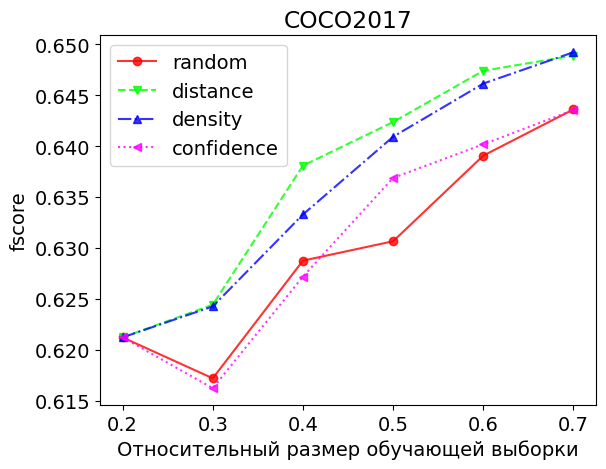

In [43]:
plot_metrics(methods, base_path, fractions, "fscore", "COCO2017")

{'random': [0.45101, 0.45295, 0.46053, 0.47038, 0.47741, 0.48149], 'active': [0.45101, 0.45632, 0.47164, 0.47766, 0.48179, 0.48608], 'density': [0.45101, 0.45476, 0.47014, 0.47858, 0.48311, 0.48662], 'confidences': [0.45101, 0.44914, 0.46389, 0.47515, 0.47979, 0.48617]}


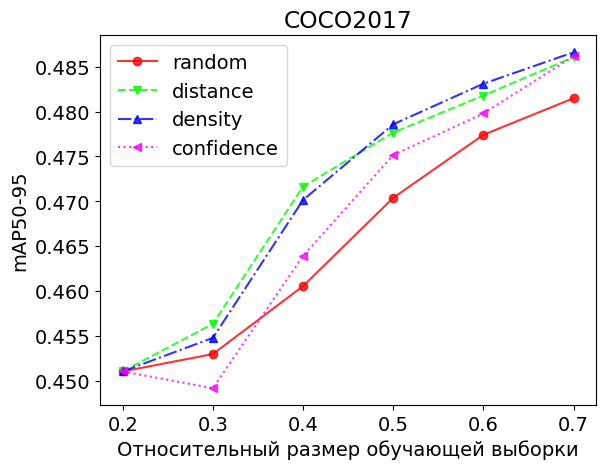

In [44]:
plot_metrics(methods, base_path, fractions, "metrics/mAP50-95(B)", "COCO2017")

{'random': [0.45101, 0.45295, 0.46053, 0.47038, 0.47741, 0.48149], 'active': [0.45101, 0.45632, 0.47164, 0.47766, 0.48179, 0.48608], 'density': [0.45101, 0.45476, 0.47014, 0.47858, 0.48311, 0.48662], 'confidences': [0.45101, 0.44914, 0.46389, 0.47515, 0.47979, 0.48617]}
{'random': [0.62120691387789, 0.6171848053562121, 0.6287491579753511, 0.6306533628624383, 0.6390694720116573, 0.6436169620038404], 'active': [0.62120691387789, 0.6244194507485459, 0.6380854546302486, 0.6423689522085837, 0.6474131616761877, 0.6488955457371701], 'density': [0.62120691387789, 0.624250361699767, 0.6332868564338943, 0.6409241694728937, 0.6461519647002751, 0.6492311579270398], 'confidences': [0.62120691387789, 0.616209799649467, 0.6271808079450301, 0.6368777988614801, 0.6401832677119493, 0.643553192119366]}


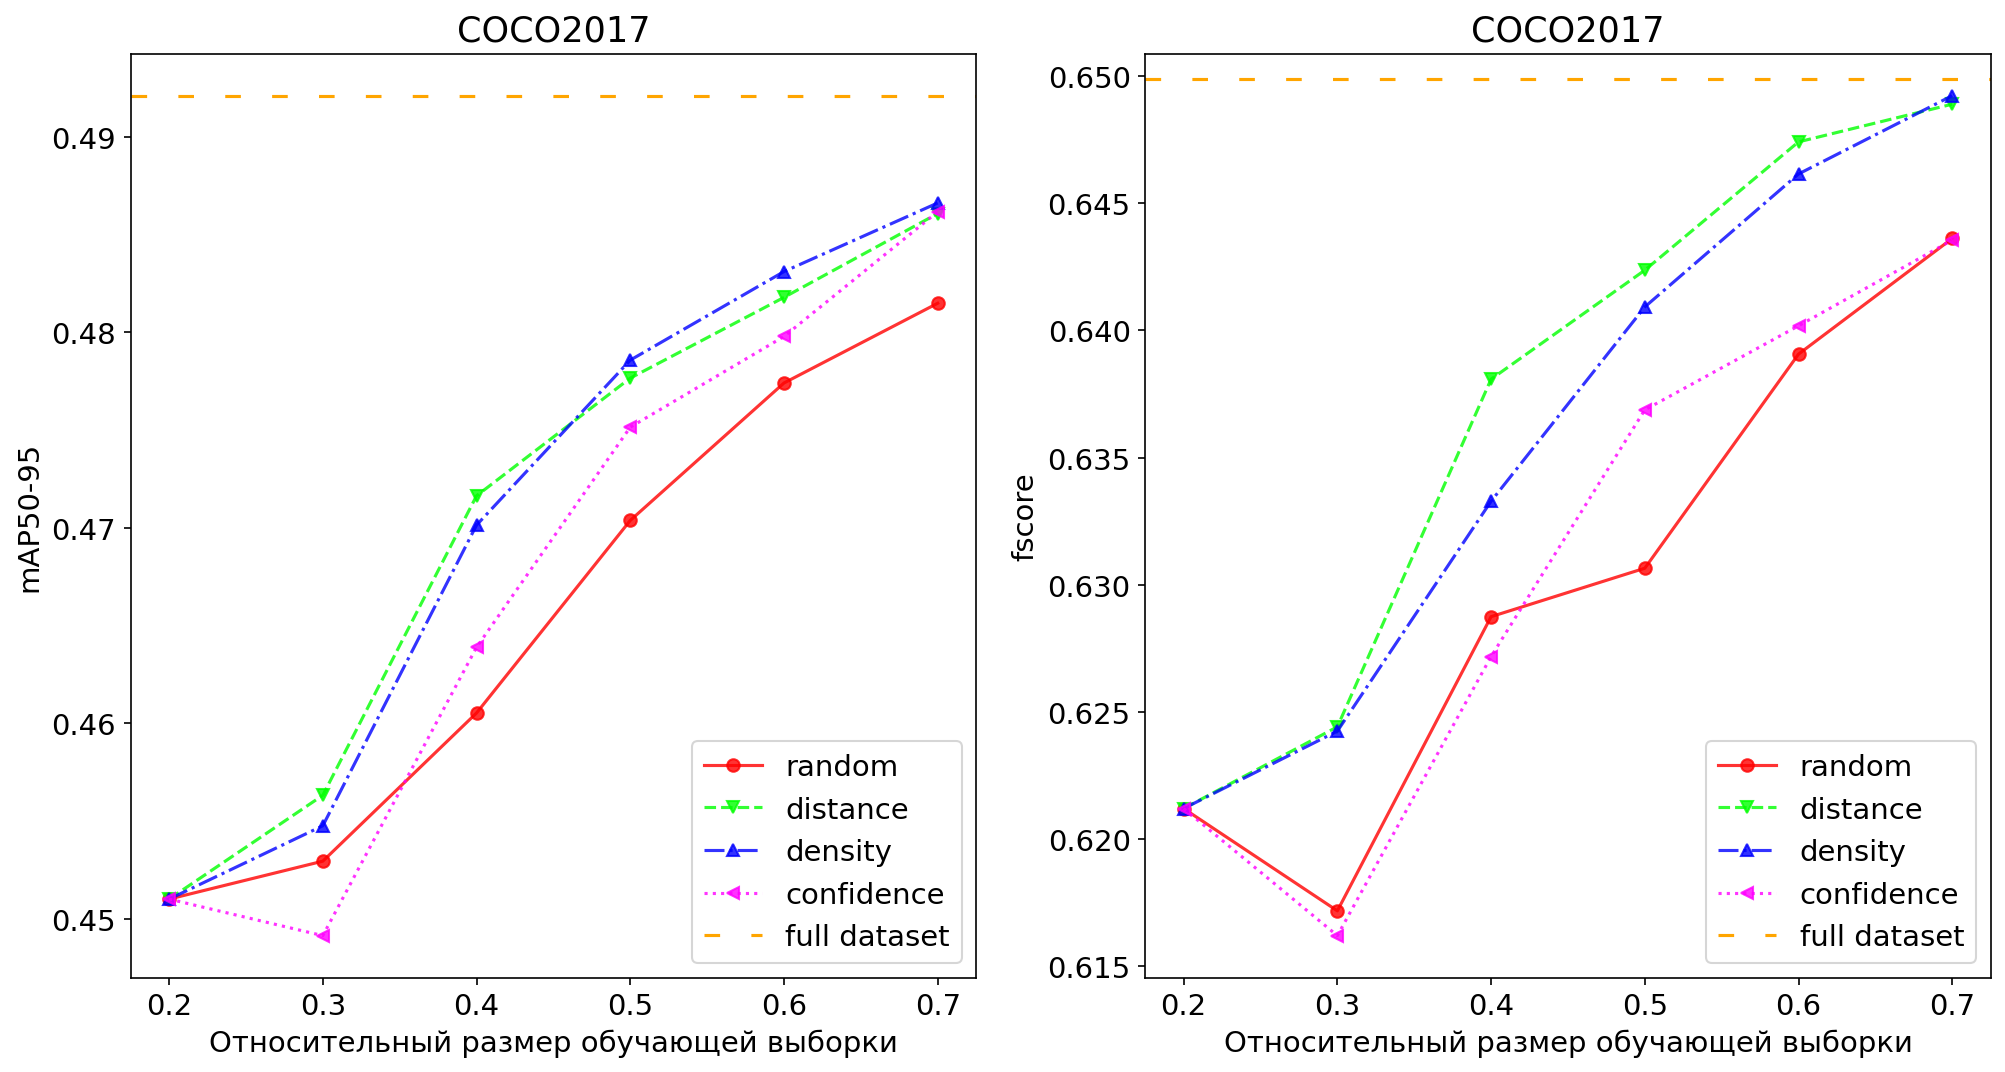

In [45]:
# Create a figure with two subplots side by side
plt.figure(figsize=(16, 8), dpi=150)  # Adjust the size as needed

# First subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plot_metrics(methods, base_path, fractions, "metrics/mAP50-95(B)", "COCO2017")
plt.axhline(y=0.49211, color="orange", linestyle=(0, (5, 10)), label="full dataset")
plt.legend()

# Second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plot_metrics(methods, base_path, fractions, "fscore", "COCO2017")
plt.axhline(y=0.6499, color="orange", linestyle=(0, (5, 10)), label="full dataset")
plt.legend()

In [46]:
get_metrics_dataframe(methods, base_path, fractions, ["metrics/mAP50-95(B)", "fscore"])

0.2     0.3     0.4     0.5     0.6  \
Metric              Method                                                
metrics/mAP50-95(B) random       0.4510  0.4530  0.4605  0.4704  0.4774   
                    active       0.4510  0.4563  0.4716  0.4777  0.4818   
                    density      0.4510  0.4548  0.4701  0.4786  0.4831   
                    confidences  0.4510  0.4491  0.4639  0.4752  0.4798   
fscore              random       0.6212  0.6172  0.6287  0.6307  0.6391   
                    active       0.6212  0.6244  0.6381  0.6424  0.6474   
                    density      0.6212  0.6243  0.6333  0.6409  0.6462   
                    confidences  0.6212  0.6162  0.6272  0.6369  0.6402   

                                    0.7  
Metric              Method               
metrics/mAP50-95(B) random       0.4815  
                    active       0.4861  
                    density      0.4866  
                    confidences  0.4862  
fscore              random       0.6436  
                    active       0.6489  
                    density      0.6492  
                    confidences  0.6436

In [47]:
import numpy as np

In [48]:
def calc_diff(methods, base_path, fractions, metric, from_sub, to_sub):
    results = get_results(methods, base_path, fractions, metric)

    return np.array(results[from_sub]) - np.array(results[to_sub])

In [49]:
calc_diff(methods, base_path, fractions, "metrics/mAP50-95(B)", "active", "confidences")

array([ 0.00e+00,  7.18e-03,  7.75e-03,  2.51e-03,  2.00e-03, -9.00e-05])

In [50]:
base_path = "/home/setupishe/ultralytics/runs/detect/VOC_{method}/results.csv"
fractions = ["0.2"] + [f"0.{i}" for i in range(3, 8)]

# Define base paths and labels
methods = {
    "random": {
        "path": "random_{fraction}",
        "label": "random",
        "color": [1, 0, 0],
    },
    "active": {
        "path": "distance_{fraction}",
        "label": "distance",
        "color": [0, 1, 0],
    },
    "density": {
        "path": "density_{fraction}",
        "label": "density",
        "color": [0, 0, 1],
    },
    "confidences": {
        "path": "confidences_{fraction}",
        "label": "confidence",
        "color": [1, 0, 1],
    },
}

In [ ]:
print("ahh")

{'random': [0.59289, 0.62191, 0.63963, 0.66019, 0.67845, 0.68334], 'active': [0.59289, 0.6354, 0.65017, 0.66589, 0.68964, 0.69557], 'density': [0.59289, 0.63037, 0.65076, 0.66923, 0.68849, 0.68879], 'confidences': [0.59289, 0.62376, 0.64619, 0.66489, 0.67831, 0.69256]}
{'random': [0.7517670932464816, 0.7754202045769094, 0.788282013976444, 0.8022014702236727, 0.8096038843638158, 0.8188159364432128], 'active': [0.7517670932464816, 0.7833654286297369, 0.7942389532639783, 0.8097870883810488, 0.8174963188721235, 0.821508022264128], 'density': [0.7517670932464816, 0.7803066388453291, 0.7962579317090298, 0.8066715875838905, 0.8118212417118745, 0.8250090835610546], 'confidences': [0.7517670932464816, 0.7826814428852609, 0.7948729116247493, 0.8070840998855091, 0.8175219290780142, 0.8258956648266512]}


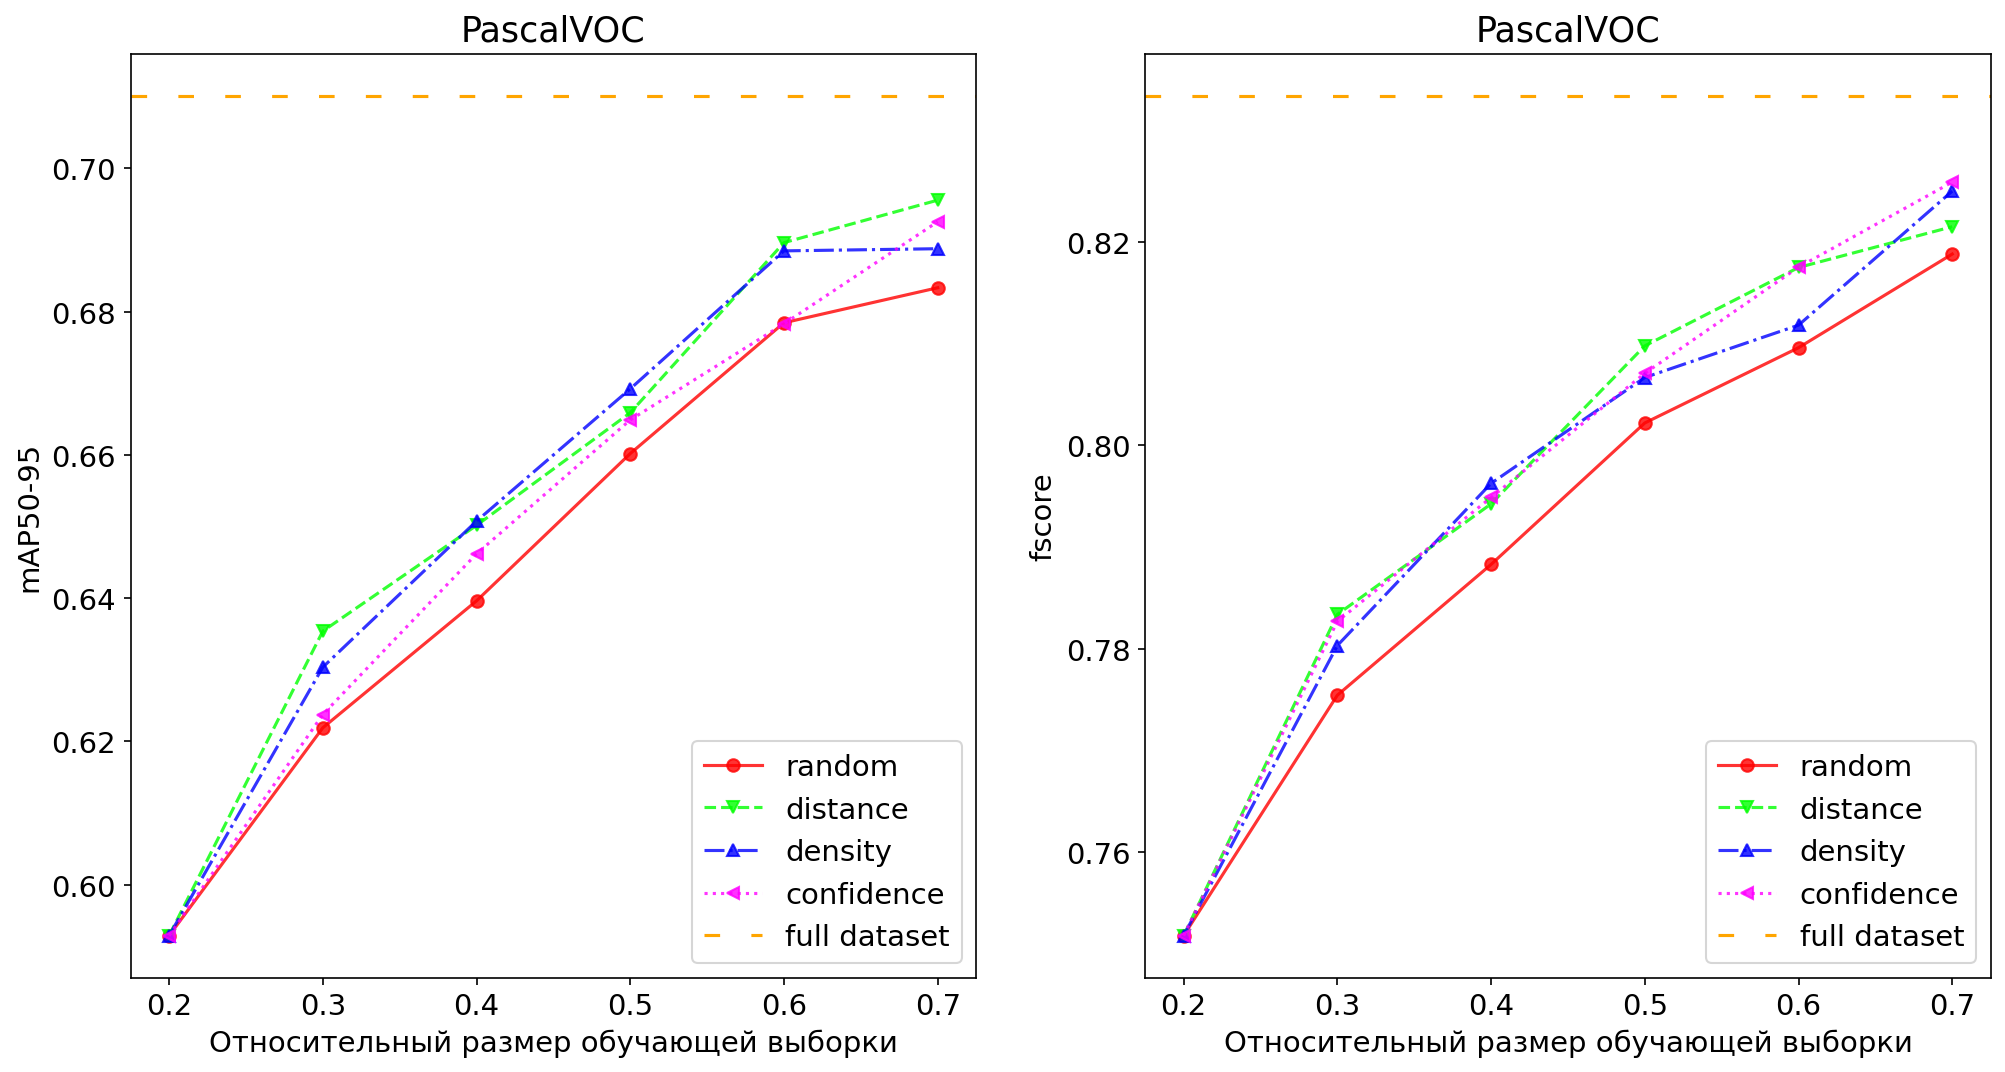

In [52]:
# Create a figure with two subplots side by side
plt.figure(figsize=(16, 8), dpi=150)  # Adjust the size as needed

# First subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plot_metrics(methods, base_path, fractions, "metrics/mAP50-95(B)", "PascalVOC")
plt.axhline(y=0.71016, color="orange", linestyle=(0, (5, 10)), label="full dataset")
plt.legend()

# Second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plot_metrics(methods, base_path, fractions, "fscore", "PascalVOC")
plt.axhline(y=0.8344, color="orange", linestyle=(0, (5, 10)), label="full dataset")
plt.legend()

In [ ]:
get_metrics_dataframe(methods, base_path, fractions, ["metrics/mAP50-95(B)", "fscore"])

0.2     0.3     0.4     0.5     0.6  \
Metric              Method                                                
metrics/mAP50-95(B) random       0.5929  0.6219  0.6396  0.6602  0.6784   
                    active       0.5929  0.6354  0.6502  0.6659  0.6896   
                    density      0.5929  0.6304  0.6508  0.6692  0.6885   
                    confidences  0.5929  0.6238  0.6462  0.6649  0.6783   
fscore              random       0.7518  0.7754  0.7883  0.8022  0.8096   
                    active       0.7518  0.7834  0.7942  0.8098  0.8175   
                    density      0.7518  0.7803  0.7963  0.8067  0.8118   
                    confidences  0.7518  0.7827  0.7949  0.8071  0.8175   

                                    0.7  
Metric              Method               
metrics/mAP50-95(B) random       0.6833  
                    active       0.6956  
                    density      0.6888  
                    confidences  0.6926  
fscore              random       0.8188  
                    active       0.8215  
                    density      0.8250  
                    confidences  0.8259

In [38]:
calc_diff(methods, base_path, fractions, "metrics/mAP50-95(B)", "active", "confidences")

array([0.     , 0.01164, 0.00398, 0.001  , 0.01133, 0.00301])

In [29]:
import pandas as pd

fractions = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
methods = ["Random", "Distance", "Density", "Confidence"]

# COCO mAP50-95 values
coco_map = {
    "Random": [0.45101, 0.45295, 0.46053, 0.47038, 0.47741, 0.48149],
    "Distance": [0.45101, 0.45632, 0.47164, 0.47766, 0.48179, 0.48608],
    "Density": [0.45101, 0.44941, 0.45865, 0.46907, 0.47289, 0.47917],
    "Confidence": [0.45101, 0.44914, 0.46389, 0.47515, 0.47979, 0.48617],
}

# COCO F-score values
coco_fscore = {
    "Random": [0.6212, 0.6172, 0.6287, 0.6307, 0.6391, 0.6436],
    "Distance": [0.6212, 0.6244, 0.6381, 0.6424, 0.6474, 0.6489],
    "Density": [0.6212, 0.6166, 0.6238, 0.6327, 0.6341, 0.6421],
    "Confidence": [0.6212, 0.6162, 0.6272, 0.6369, 0.6402, 0.6436],
}

# VOC mAP50-95 values
voc_map = {
    "Random": [0.59289, 0.62191, 0.63963, 0.66019, 0.67845, 0.68334],
    "Distance": [0.59289, 0.63859, 0.65111, 0.66572, 0.68463, 0.69035],
    "Density": [0.59289, 0.61370, 0.64206, 0.65957, 0.68556, 0.68870],
    "Confidence": [0.59289, 0.62376, 0.64808, 0.65917, 0.67107, 0.68396],
}

# VOC F-score values
voc_fscore = {
    "Random": [0.7518, 0.7754, 0.7883, 0.8022, 0.8096, 0.8188],
    "Distance": [0.7518, 0.7875, 0.7962, 0.8091, 0.8115, 0.8196],
    "Density": [0.7518, 0.7704, 0.7871, 0.8038, 0.8134, 0.8243],
    "Confidence": [0.7518, 0.7827, 0.7941, 0.8017, 0.8123, 0.8189],
}

# Create DataFrames
df_coco_map = pd.DataFrame(coco_map, index=fractions).round(4).T
df_coco_fscore = pd.DataFrame(coco_fscore, index=fractions).round(4).T
df_voc_map = pd.DataFrame(voc_map, index=fractions).round(4).T
df_voc_fscore = pd.DataFrame(voc_fscore, index=fractions).round(4).T

In [33]:
df_voc_fscore

,0.2,0.3,0.4,0.5,0.6,0.7
Random,0.7518,0.7754,0.7883,0.8022,0.8096,0.8188
Distance,0.7518,0.7875,0.7962,0.8091,0.8115,0.8196
Density,0.7518,0.7704,0.7871,0.8038,0.8134,0.8243
Confidence,0.7518,0.7827,0.7941,0.8017,0.8123,0.8189


In [28]:
df_coco

,Fraction,Method,mAP50-95,F-score
6,0.2,Density,0.4494,0.6166
18,0.2,Density,0.4729,0.6341
0,0.2,random,0.4510,0.6212
12,0.2,random,0.4704,0.6307
7,0.3,Confidence,0.4491,0.6162
19,0.3,Confidence,0.4798,0.6402
1,0.3,Distance,0.4510,0.6212
13,0.3,Distance,0.4777,0.6424
2,0.4,Density,0.4510,0.6212
14,0.4,Density,0.4691,0.6327
